 # Titanic Dataset

 <img src="titanic.png">

 Fragestellung: Wie können wir effizient vorhersagen, wer überlebt hat und wer nicht? Stimmt die Behauptung, dass
 Frauen und Kinder zuerst gerettet wurden? Welche Eigenschaftn entscheiden am ehesten über das Überleben?
 ------------
 *__Schwerpunkte__*:

 - __Sabine__: Untersuchung von GridSearch Parametern, Diskussion Feature Engineering, Fachrecherche für Data Insights
     für Kategorisierungen (Passagierliste, Titel-Bezeichnungen, etc.), Ausarbeitung von Texten


 - __Saskia__: Erstellen von Modellen und Scalern, Parameter-Tests, Diskussion Feature Engineering, statistische 
     Überlegungen zum Cross Validation Score


 - __Jan__: Explorative Datenanalyse, Pipeline-Erstellung (Imputer/Transformer/Scaler-Klassen, inklusive 
     Panda-Kompatibilität), Diskussion Feature Engineering, Code Style/Formatierung, Diskussion Modellauswahl


### Die Titanic:
- Passagierschif der britischen Reederei White Star Line
- Wurde am 2. April 1912 in Dienst gestellt und war das größte Schiff ihrer Zeit.
- War für die Route Southampton – Cherbourg – Queenstown – New York vorgesehen.
- Auf ihrer Jungfernfahrt kollidierte sie am 14. April 1912 um 23:40 etwa 300 Seemeilen südöstlich von Neufundland mit einem Eiseberg und sank ca. 3 Stunden später.
- 1514 von 2200 Personen an Bord kamen dabei ums Leben.
- Grund war unter anderem die unzureichende Menge an Rettungsbooten.
- Zählt zu den größten Katastrophen der Seefahrt.

<img src='https://upload.wikimedia.org/wikipedia/commons/5/51/Titanic_voyage_map.png'>

 # 1) Imports:
 Zuerst importieren wir notwendige Libraries und viele Elemente aus sklearn:

In [1]:
# Libraries:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# Strategic imports:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
# Machine Learning Models:
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.naive_bayes import CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
# Setups:
SEED = 42
np.random.seed(SEED)
sns.set()



 # 2) Laden des Datensets:
 Das Datenset wird geladen und erste Eindrücke gewonnen!

In [2]:
df_train = pd.read_csv('train.csv', index_col='PassengerId')
df_test = pd.read_csv('test.csv', index_col='PassengerId')


 Zunächste betrachten wir die ersten Zeilen des Datensets:

In [3]:
df_train.head()


Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  
PassengerId                                                          
1                1      0         A/5 21171   7.2500   NaN        S  
2                1      0          PC 17599  71.2833   C85        C  
3                0      0  STON/O2. 3101282   7.9250   NaN        S  
4                1      0            113803  53.1000  C123        S  
5                0      0            373450   8.0500   NaN        S

 Außerdem lassen wir uns einige Statistiken anzeigen (nur von numerischen Features):

In [4]:
df_train.describe()


Survived      Pclass         Age       SibSp       Parch        Fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200

 Das Datenset hat folgende Spalten:

In [5]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


 Die Spalten haben folgende Bedeutung:
 * `PassengerId`: Eindeutige Identifikationsnummer des Passagiers, wurde schon als Index der Datensets verwendet und
   taucht deshalb hier nicht mehr auf.

 * `Survived`: Wer hat überlebt? Dies ist unsere Zielspalte (Label).

 * `Pclass`: Ticket Klasse (1, 2 oder 3) -> ordinale Skala. Dieses Feature sagt noch nichts darüber aus, wo die Zimmer
   auf dem Schiff waren (weiter oben an Deck, oder tiefer im Schiff? Dies könnte anhand der `Cabin` erklärt werden.

 * `Name`: Name des Passagiers. Dieser enthält auch Titel wie "Mr" oder "Mrs". Bei Frauen kann so vielleicht zwischen
   verheiratet ("Mrs") und unverheiratet ("Ms") unterschieden werden. Eventuell hat dies einen Einfluss auf die
   Überlebenswahrscheinlichkeit.

 * `Sex`: Entweder "male" oder "female". Sollte vor Benutzung als `0`/`1` kodiert werden.

 * `Age`: Alter des Passagiers -> Rationale Skala, aber eventuell ist eine Einteilung in Kategorien sinnvoll?

 * `SibSp`: Anzahl der Geschwister (Siblings) und Ehepartner (Spouses).

 * `Parch`: Anzahl der Eltern (Parents) und Kinder (Children) des Passagiers.

 * `Ticket`: String oder Zahlenfolge, die die Ticketnummer des Passagiers angibt. Eine Ticket Nummer kann sich bei
   verschiedenen Personen finden, die sich das Ticket also teilen.

 * `Fare`: Der Ticketpreis, welcher wahrscheinlich mit Deck (siehe `Cabin`) und Klasse (siehe `Pclass`) korreliert.
   Scheinbar bezieht sich der Preis auf das Ticket. Die Erstellung eines Features "Preis/Person" scheint daher
   sinnvoll.

 * `Cabin`: Kabinennummer (nur für sehr wenige Passagiere vorhanden). Der Buchstabe steht für das Deck, was eventuell
   ein wichtiges Indiz für die Evakuierbarkeit des Passagiers zulässt.

 * `Embarked`: Hafen, an dem der Passagier an Bord gegangen ist (drei Möglichkeiten: Southampton, Cherbourg,
   Queenstown). Eventuell korreliert dieser mit der Klasse (Reichtum der Bewohner an den Häfen?). Eventuell wird dieses
   Feature aber auch weggelassen, da es keinen großen Einfluss auf die Überlebenschancen haben sollte.

 # 3) Explorative Datenanalyse
 Zunächst schauen wir uns die einzelnen Features genauer an. Dazu legen wir erst eine Arbeitskopie des
 Trainingsdatensatzes an und schauen uns außerdem einen Pairplot, sowie die Korrelationsmatrix an:

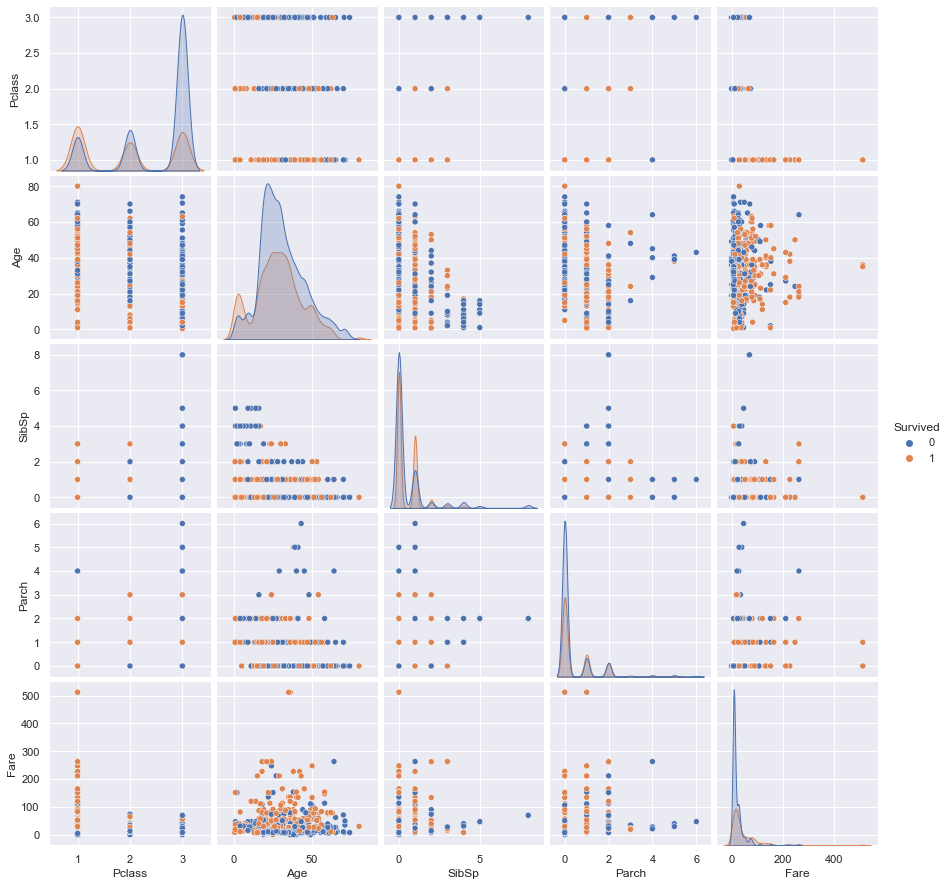

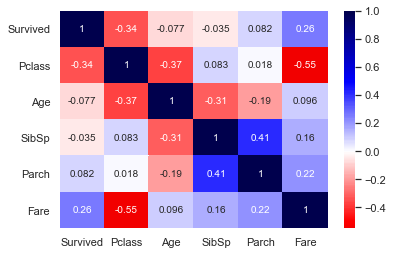

In [6]:
df = df_train.copy()
sns.pairplot(df, hue='Survived', kind='scatter', diag_kind='kde', diag_kws={'bw_adjust': 0.5})
plt.show()
sns.heatmap(df.corr(), cmap='seismic_r', annot=True, center=0)
plt.show()


 Auffällig ist schon jetzt, dass die Überlebensrate am stärksten mit der `Pclass` und `Fare` korreliert, welche
 ebenfalls beide korrelieren. Es ist zu beachten, dass kategorische Features (beispielsweise `Sex`) aktuell noch nicht
 in der Korrelationsmatrix auftauchen (dazu müssten sie erst in eine Zahlenskala transformiert werden):

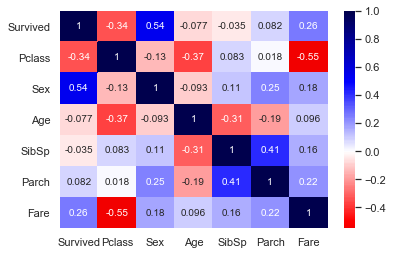

In [7]:
df.replace({'male': 0, 'female': 1}, inplace=True)
sns.heatmap(df.corr(), cmap='seismic_r', annot=True, center=0)
plt.show()


 Offensichtlich ist die Korrelation mit dem Geschlecht am stärksten!

 ## 3.1) Fehlende Werte
 Ein wichtiger erster Schritt ist festzustellen, in welchem der Features Werte fehlen (`NaN`). Diese müssen dann
 eventuell durch Imputation-Strategien durch sinnvolle Werte ersetzt werden.

In [8]:
def check_missing_values(df, title=None):
    if title is not None:
        print(title)
    missing_sth = False
    for name in df.columns:
        nan_count = df[name].isnull().values.sum()
        if nan_count > 0:
            missing_sth = True
            print(f'Column "{name}" is missing {nan_count} of {df.shape[0]} values')
    if not missing_sth:
        print('No column has missing data!')
    print()


check_missing_values(df_train, title='Training Set:')
check_missing_values(df_test, title='Test Set:')


Training Set:
Column "Age" is missing 177 of 891 values
Column "Cabin" is missing 687 of 891 values
Column "Embarked" is missing 2 of 891 values

Test Set:
Column "Age" is missing 86 of 418 values
Column "Fare" is missing 1 of 418 values
Column "Cabin" is missing 327 of 418 values



 Wir sehen, dass `Age` recht viele fehlende Werte hat, `Embarked` nur zwei Stück und das `Cabin` knapp 3/4 aller Werte
 fehlen!

 ### 3.1.1) Imputation des "Age" Features
 Für die Imputation kann man naiv den Median/Mittelwert aller vorhandenen Werte einsetzen. Wir können jedoch bessere
 Ergebnisse erzielen, wenn wir uns anschauen, welche Werte am besten mit `Age` korrelieren und entsprechend auffüllen:

In [9]:
df.corr()['Age'].sort_values(ascending=False, key=abs)


Age         1.000000
Pclass     -0.369226
SibSp      -0.308247
Parch      -0.189119
Fare        0.096067
Sex        -0.093254
Survived   -0.077221
Name: Age, dtype: float64

 In diesem Fall wäre dies das `Pclass` Feature. Wir könnten also prinzipiell Klassen-Mittelwerte oder Mediane für das
 Alter berechnen und diese für die Imputation nutzen. Wir gehen jedoch einen Schritt weiter und schauen uns ein
 neues Feature an, welches wir aus dem Namen generieren können (mehr dazu in Abschnitt 3.2.2):

In [10]:
df['Title'] = df['Name'].str.extract(pat='([A-Z][a-z]+\.)')
df['Title'].value_counts()


Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Major.         2
Col.           2
Mlle.          2
Ms.            1
Don.           1
Countess.      1
Lady.          1
Mme.           1
Capt.          1
Sir.           1
Jonkheer.      1
Name: Title, dtype: int64

 Viele Titel kommen nur selten oder ein einziges Mal vor. Wir fassen diese zusammen:

In [11]:
df['Title'][~df['Title'].isin(['Mr.', 'Miss.', 'Mrs.', 'Master.'])] = 'Misc.'
df['Title'].value_counts()


Mr.        517
Miss.      182
Mrs.       125
Master.     40
Misc.       27
Name: Title, dtype: int64

In [12]:
df.groupby(['Title'])['Age'].describe()


count       mean        std    min     25%   50%    75%   max
Title                                                                 
Master.   36.0   4.574167   3.619872   0.42   1.000   3.5   8.00  12.0
Misc.     26.0  42.384615  13.200233  23.00  29.000  44.5  51.75  70.0
Miss.    146.0  21.773973  12.990292   0.75  14.125  21.0  30.00  63.0
Mr.      398.0  32.368090  12.708793  11.00  23.000  30.0  39.00  80.0
Mrs.     108.0  35.898148  11.433628  14.00  27.750  35.0  44.00  63.0

 Wir sehen, dass die `Title`-Mediane deutliche Unterschiede zeigen, was unseren Ansatz bestätigt, den Titel zur
 Imputation zu nutzen. Im Folgenden füllen wir die fehlenden Werte mit diesen Medianen auf:

In [13]:
df['Age'].fillna(df.groupby('Title')['Age'].transform('median'), inplace=True)


 Um zu zeigen, dass unser Ansatz besser als `Pclass`-Mediane oder der Gesamt-Median ist, schauen wir uns diese hier an:

In [14]:
df.groupby(['Pclass'])['Age'].describe()


count       mean        std   min   25%   50%    75%   max
Pclass                                                            
1       216.0  37.300556  13.997633  0.92  29.0  35.0  47.25  80.0
2       184.0  29.787120  13.605174  0.67  23.0  30.0  36.00  70.0
3       491.0  25.757475  11.113889  0.42  20.0  27.0  30.00  74.0

In [15]:
df['Age'].describe()


count    891.000000
mean      29.387957
std       13.262592
min        0.420000
25%       21.000000
50%       30.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64

 Für "Master" (kleine Jungen) wären diese Mediane beispielsweise deutlich schlechter gewesen als die von uns gewählten.

In [16]:
check_missing_values(df)


Column "Cabin" is missing 687 of 891 values
Column "Embarked" is missing 2 of 891 values



 Die Features `Cabin` und `Embarked` haben noch fehlende Werte, wir werden jedoch beide vernachlässigen, was ein
 Imputen überflüssig macht. In `Cabin` fehlen zu viele Werte (auch wenn die Deck-Nummer wahrscheinlich wertvolle
 Informationen enthält) und `Embarked` sollte keinen großen Einfluss auf das Überleben haben.

 Vorsichtshalber schauen wir auch einmal in die Kaggle-Test-Daten und stellen fest, das hier, zusätzlich zu fehldenden
 Werten in `Age`, `Cabin` und `Embarked`, auch ein Wert in `Fare` fehlt.

In [17]:
check_missing_values(df_test)
df_test[df_test['Fare'].isnull()]


Column "Age" is missing 86 of 418 values
Column "Fare" is missing 1 of 418 values
Column "Cabin" is missing 327 of 418 values



Pclass                Name   Sex   Age  SibSp  Parch Ticket  \
PassengerId                                                                
1044              3  Storey, Mr. Thomas  male  60.5      0      0   3701   

             Fare Cabin Embarked  
PassengerId                       
1044          NaN   NaN        S

 Generell macht es Sinn sich für jedes der Features eine Imputer-Strategie zu überlegen, da man den Test-Datensatz
 idealerweise erst nach der Modell-Wahl bekommt und immer Daten fehlen können.

 ### 3.1.2) Imputer Klasse:
 Wir schreiben eine Imputer Funktion um später einfacher fehlende Werte zu ersetzen (Spalten, die nicht weiter benutzt
 werden, werden gedroppt, hier: `Cabin` und `Embarked`):

In [18]:
class TitanicImputer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        assert isinstance(X, pd.DataFrame), 'This imputer is designed to work on pandas DataFrames!'
        titles = self._get_titles(X)
        self.median_age_per_title = pd.concat((titles, X['Age']), axis=1).groupby('Title')['Age'].median()
        self.median_fare_per_class = X.groupby('Pclass')['Fare'].median()
        return self

    def transform(self, X, copy=True):
        assert isinstance(X, pd.DataFrame), 'This imputer is designed to work on pandas DataFrames!'
        if copy:
            X = X.copy()
        titles = self._get_titles(X)
        X.loc[X['Age'].isnull(), 'Age'] = titles.map(self.median_age_per_title)
        X.loc[X['Fare'].isnull(),'Fare'] = X['Pclass'].map(self.median_fare_per_class)
        X.drop(['Cabin', 'Embarked'], axis=1, inplace=True)  # Unused columns with nans are dropped instead of filling!
        return X

    @staticmethod
    def _get_titles(X):
        # Extract regex; expand=False: if just one capture group (round brackets), return Series, not DataFrame!
        return X['Name'].str.extract(pat='([A-Z][a-z]+\.)', expand=False).rename('Title')


imputer = TitanicImputer()
df_train_imputed = imputer.fit_transform(df_train)
df_test_imputed = imputer.transform(df_test)
check_missing_values(df_train, title='Training Set:')
check_missing_values(df_test, title='Test Set:')
check_missing_values(df_train_imputed, title='Training Set (Imputed):')
check_missing_values(df_test_imputed, title='Test Set (Imputed):')



Training Set:
Column "Age" is missing 177 of 891 values
Column "Cabin" is missing 687 of 891 values
Column "Embarked" is missing 2 of 891 values

Test Set:
Column "Age" is missing 86 of 418 values
Column "Fare" is missing 1 of 418 values
Column "Cabin" is missing 327 of 418 values

Training Set (Imputed):
No column has missing data!

Test Set (Imputed):
No column has missing data!



 ## 3.2) Sicht der Daten, Generierung neuer und Vernachlässigung unnötiger Features
 Wir wollen nun einmal die einzelnen Features durchgehen und bewerten:

 ### 3.2.1) Ticket Klasse `Pclass`

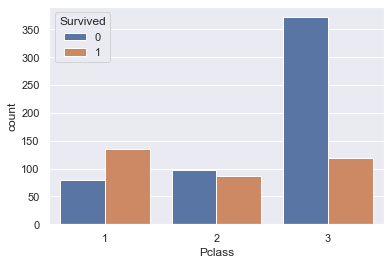

In [19]:
sns.countplot(x='Pclass', data=df, hue='Survived')
plt.show()


 Die Ticket Klasse ist ein gutes Indiz für das Überleben der Passagiere. In der dritten Klasse sinken die Chancen das
 Unglück zu überleben drastisch. Dieses Feature hat eine ordinale Skala und kann von uns so weiterverwendet werden.
 Eventuell müssen wir noch skalieren (`StandardScaler` oder `MinMaxScaler` bieten sich an).

 ### 3.2.2) Passagier `Name`

In [20]:
df['Name'].head(10)


PassengerId
1                               Braund, Mr. Owen Harris
2     Cumings, Mrs. John Bradley (Florence Briggs Th...
3                                Heikkinen, Miss. Laina
4          Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                              Allen, Mr. William Henry
6                                      Moran, Mr. James
7                               McCarthy, Mr. Timothy J
8                        Palsson, Master. Gosta Leonard
9     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
10                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

 `Name` enthält den Namen der Passagiere und hat dementsprechend eine Nominalskala. Wir haben stichprobenartig
 untersucht, ob die Cross channel Passagiere (siehe: https://en.wikipedia.org/wiki/Passengers_of_the_Titanic) im
 Datensatz vorkommen (wir haben außergewöhnliche/auffällige Namen genutzt):

In [21]:
cross_channel_samples = ['DeGrasse', 'Dyer-Edwardes', 'Lenox-Conyngham', 'Osborne', 'Remesch']
if df['Name'].str.contains('|'.join(cross_channel_samples)).any():
    print('(Some) cross channel passengers are included!')
else:
    print('No cross channel passengers were found!')


No cross channel passengers were found!


 Obwohl wir den Namen selbst nicht benutzen können, ist es uns möglich ein interessantes Feature aus dem Datensatz zu
 extrahieren: den Titel der Person! Dieser wird immer groß geschrieben und endet in einem Punkt und wir können ihn mit
 einer Regular Expression erfassen (dieses Feature wurde schon in Abschnitt 3.1.1 zur Imputation benutzt und wird hier
 weiter erklärt):

In [22]:
df['Title'] = df['Name'].str.extract(pat='([A-Z][a-z]+\.)')
df['Title'].value_counts()


Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Major.         2
Col.           2
Mlle.          2
Ms.            1
Don.           1
Countess.      1
Lady.          1
Mme.           1
Capt.          1
Sir.           1
Jonkheer.      1
Name: Title, dtype: int64

 Sehr viele der selteneren Titel tauchen nur wenige Male auf und werden von uns zu `Misc.` (Miscellaneous =
 Verschiedenes) zusammengefasst:

In [23]:
df['Title'][~df['Title'].isin(['Mr.', 'Miss.', 'Mrs.', 'Master.'])] = 'Misc.'
df[df['Title'].isin(['Misc.'])].head()


Survived  Pclass                               Name  Sex   Age  \
PassengerId                                                                   
31                  0       1           Uruchurtu, Don. Manuel E    0  40.0   
150                 0       2  Byles, Rev. Thomas Roussel Davids    0  42.0   
151                 0       2         Bateman, Rev. Robert James    0  51.0   
246                 0       1        Minahan, Dr. William Edward    0  44.0   
250                 0       2      Carter, Rev. Ernest Courtenay    0  54.0   

             SibSp  Parch       Ticket     Fare Cabin Embarked  Title  
PassengerId                                                            
31               0      0     PC 17601  27.7208   NaN        C  Misc.  
150              0      0       244310  13.0000   NaN        S  Misc.  
151              0      0  S.O.P. 1166  12.5250   NaN        S  Misc.  
246              2      0        19928  90.0000   C78        Q  Misc.  
250              1      0       244252  26.0000   NaN        S  Misc.

In [24]:
df['Title'].value_counts()


Mr.        517
Miss.      182
Mrs.       125
Master.     40
Misc.       27
Name: Title, dtype: int64

 Schauen wir uns die `Misc.`-Titel ein wenig genauer im Hinblick auf die Überlebensrate an:

In [25]:
df[df['Title'] == 'Misc.'].sort_values(by='Survived')


Survived  Pclass  \
PassengerId                     
31                  0       1   
823                 0       1   
767                 0       1   
746                 0       1   
695                 0       1   
849                 0       2   
537                 0       1   
627                 0       2   
887                 0       2   
150                 0       2   
151                 0       2   
318                 0       2   
246                 0       1   
250                 0       2   
399                 0       2   
797                 1       1   
760                 1       1   
711                 1       1   
444                 1       2   
642                 1       1   
633                 1       1   
600                 1       1   
557                 1       1   
370                 1       1   
450                 1       1   
648                 1       1   
661                 1       1   

                                                          Name  Sex   Age  \
PassengerId                                                                 
31                                    Uruchurtu, Don. Manuel E    0  40.0   
823                            Reuchlin, Jonkheer. John George    0  38.0   
767                                  Brewe, Dr. Arthur Jackson    0  44.5   
746                               Crosby, Capt. Edward Gifford    0  70.0   
695                                            Weir, Col. John    0  60.0   
849                                          Harper, Rev. John    0  28.0   
537                          Butt, Major. Archibald Willingham    0  45.0   
627                             Kirkland, Rev. Charles Leonard    0  57.0   
887                                      Montvila, Rev. Juozas    0  27.0   
150                          Byles, Rev. Thomas Roussel Davids    0  42.0   
151                                 Bateman, Rev. Robert James    0  51.0   
318                                       Moraweck, Dr. Ernest    0  54.0   
246                                Minahan, Dr. William Edward    0  44.0   
250                              Carter, Rev. Ernest Courtenay    0  54.0   
399                                           Pain, Dr. Alfred    0  23.0   
797                                Leader, Dr. Alice (Farnham)    1  49.0   
760          Rothes, the Countess. of (Lucy Noel Martha Dye...    1  33.0   
711           Mayne, Mlle. Berthe Antonine ("Mrs de Villiers")    1  24.0   
444                                  Reynaldo, Ms. Encarnacion    1  28.0   
642                                       Sagesser, Mlle. Emma    1  24.0   
633                                  Stahelin-Maeglin, Dr. Max    0  32.0   
600               Duff Gordon, Sir. Cosmo Edmund ("Mr Morgan")    0  49.0   
557          Duff Gordon, Lady. (Lucille Christiana Sutherl...    1  48.0   
370                              Aubart, Mme. Leontine Pauline    1  24.0   
450                             Peuchen, Major. Arthur Godfrey    0  52.0   
648                        Simonius-Blumer, Col. Oberst Alfons    0  56.0   
661                              Frauenthal, Dr. Henry William    0  50.0   

             SibSp  Parch       Ticket      Fare Cabin Embarked  Title  
PassengerId                                                             
31               0      0     PC 17601   27.7208   NaN        C  Misc.  
823              0      0        19972    0.0000   NaN        S  Misc.  
767              0      0       112379   39.6000   NaN        C  Misc.  
746              1      1    WE/P 5735   71.0000   B22        S  Misc.  
695              0      0       113800   26.5500   NaN        S  Misc.  
849              0      1       248727   33.0000   NaN        S  Misc.  
537              0      0       113050   26.5500   B38        S  Misc.  
627              0      0       219533   12.3500   NaN        Q  Misc.  
887              0      0       211536   13.0000   NaN        S  Misc.  
150              0

 Interessant ist, dass (wie bereits in 3.1.1 gezeigt), das Alter der Passagiere mit seltenen Titeln sehr hoch ist, was
 sich mit dem hohen Rang (Militär) oder geistlichen Würden (z.B. "Rev." für "Reverend"), sowie Adelsstand (z.B.
 "Countess") begründen lässt.

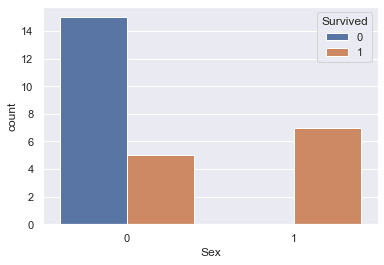

In [26]:
sns.countplot(x='Sex', data=df[df['Title'] == 'Misc.'], hue='Survived')


 Außerdem kann man sehen, dass alle Frauen dieser Kategorie überlebt haben, von den
 Männern aber überdurchschnittlich viele nicht. Wir schätzen dieses Feature von daher als recht wichtig ein.

 Zu guter Letzt wandeln wir die immer noch nominale Skala des Titels in 5 binäre Features um, die von unseren
 Algorithmen verwendet werden können:

In [27]:
df = pd.get_dummies(df, columns=['Title'])
df.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Survived       891 non-null    int64  
 1   Pclass         891 non-null    int64  
 2   Name           891 non-null    object 
 3   Sex            891 non-null    int64  
 4   Age            891 non-null    float64
 5   SibSp          891 non-null    int64  
 6   Parch          891 non-null    int64  
 7   Ticket         891 non-null    object 
 8   Fare           891 non-null    float64
 9   Cabin          204 non-null    object 
 10  Embarked       889 non-null    object 
 11  Title_Master.  891 non-null    uint8  
 12  Title_Misc.    891 non-null    uint8  
 13  Title_Miss.    891 non-null    uint8  
 14  Title_Mr.      891 non-null    uint8  
 15  Title_Mrs.     891 non-null    uint8  
dtypes: float64(2), int64(5), object(4), uint8(5)
memory usage: 120.2+ KB


 ### 3.2.3) Geschlecht `Sex`

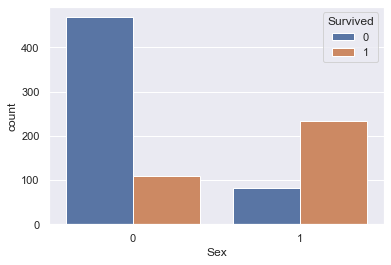

In [28]:
sns.countplot(x='Sex', data=df, hue='Survived')
plt.show()


 Das Geschlecht hat einen sehr starken Einfluss auf die Überlebenschancen! Aktuell hat dieses Feature eine Nominalskala
 ("male"/"female") und wird von uns in ein binäres Feature umgewandelt:

In [29]:
df.replace({'male': 0, 'female': 1}, inplace=True)
df['Sex'].value_counts()



0    577
1    314
Name: Sex, dtype: int64

 ### 3.2.4) Alter `Age`
 Dieses Feature zeigt das Alter der Passagiere an.

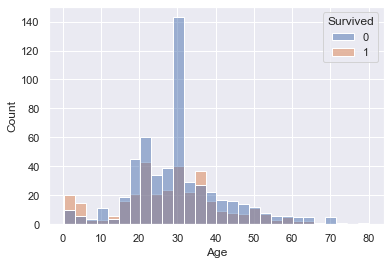

In [30]:
sns.histplot(x='Age', data=df, hue='Survived')


 Aus dem Histogramm lässt sich erkennen, dass junge Kinder viel höhere Überlebenschancen hatten als Erwachsene. Sehr
 auffällig ist der hohe Anteil von Ertrinkenden bei den ca. 30-jährigen. Entsprechend dieser Statistik haben wir uns
 für eine Kategorisierung der Daten entschieden. Ein paar Entscheidungskriterien:

 * 5 war das Einschulungsalter zur damaligen Zeit.

 * Der älteste "Master" im Datenset ist 12 Jahre alt.

 * Volljährigkeit mit 18.

 * Peaks im Graph bei ca. 20 und ca. 30 rechtfertigen Abschnitte von 18-25, sowie von 35 bis 45.

 * Sehr alte Menschen (über 60) scheinen keine hohen Überlebenschancen zu haben.

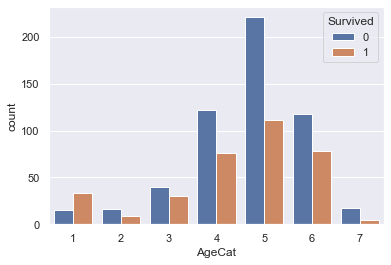

In [31]:
df['AgeCat'] = pd.cut(df['Age'], bins=[0, 5, 12, 18, 25, 35, 60, np.inf], labels=[1, 2, 3, 4, 5, 6, 7]).astype(int)
sns.countplot(x='AgeCat', data=df, hue='Survived')



 ### 3.2.5) `SibSp` und `Parch`
 Diese Features beschreiben die Anzahl der Geschwister (Siblings) und Ehepartner (Spouses), sowie die Anzahl der Eltern
 (Parents) und Kinder (Children):

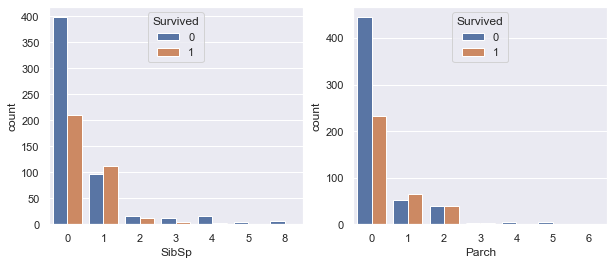

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.countplot(x='SibSp', data=df, hue='Survived', ax=axes[0])
sns.countplot(x='Parch', data=df, hue='Survived', ax=axes[1])


 Beide Features zeigen einen sehr ähnlichen Zusammenhang zur Überlebensrate und werden von uns von daher zur
 Familiengröße ´FamilySize´ zusammengefasst:

In [33]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1  # +1: die Person selbst wird mit eingerechnet!
df['FamilySize'].value_counts()


1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: FamilySize, dtype: int64

 Eine interessante Entdeckung war ein Geschwisterpaar (`SibSp`=1), welches ohne Eltern (`Parch`=0) auf Reisen waren.
 Beide (12 und 14 Jahre) haben überlebt!

In [34]:
df[df['Ticket']=='2651']



Survived  Pclass                          Name  Sex   Age  SibSp  \
PassengerId                                                                     
40                  1       3   Nicola-Yarred, Miss. Jamila    1  14.0      1   
126                 1       3  Nicola-Yarred, Master. Elias    0  12.0      1   

             Parch Ticket     Fare Cabin Embarked  Title_Master.  Title_Misc.  \
PassengerId                                                                     
40               0   2651  11.2417   NaN        C              0            0   
126              0   2651  11.2417   NaN        C              1            0   

             Title_Miss.  Title_Mr.  Title_Mrs.  AgeCat  FamilySize  
PassengerId                                                          
40                     1          0           0       3           2  
126                    0          0           0       2           2

 ### 3.2.6) Ticketnummer `Ticket`
 Die Ticketnummer kann von uns nicht direkt verwendet werden, da es scheinbar kein eindeutiges System für die Zahlen
 und Buchstaben gibt. Man kann weder die Kabine, noch das Deck ableiten und es scheint, dass unterschiedliche
 Ausgabestellen andere Konventionen verwenden. Was wir jedoch tun können, ist die Ticketnummer zu verwenden um
 Passagiere zusammenzufassen, die zusammen gereist sind. Wir führen deshalb das neue Feature `GroupSize` ein welches
 nicht unähnlich zur `FamilySize` ist (allerdings können auch Freunde zusammen reisen und Familien können mehrere
 Tickets nutzen, es besteht also ein Mehrwert dieses Features):

In [35]:
df['GroupSize'] = df['Ticket'].map(df['Ticket'].value_counts())
df['GroupSize'].value_counts()



1    547
2    188
3     63
4     44
7     21
6     18
5     10
Name: GroupSize, dtype: int64

 Im Folgenden zeigen wir die ersten drei Reisegruppen mit dem Maximum von 7 Personen in `GroupSize`:
 * `Ticket=CA. 2434`: Familie Sage mit 11 Personen, die also mehrere Tickets besaßen. Alle 7 von diesem Ticket starben.

 * `Ticket=347082`: Familie Andersson mit 7 Personen, alle mit diesem Ticket. Alle starben.

 * `Ticket=1601`: Eine asiatische Reisegruppe, die nicht verwandt war, von denen 5 überlebten.

 Für die erste Gruppe gibt es leider keine gute Möglichkeit die anderen 4 Familienmitglieder (auf mindestens einem
 weiteren Ticket) ausfindig zu machen um zu überprüfen ob diese überlebt haben.

In [36]:
columns = ['Name', 'Ticket', 'GroupSize', 'FamilySize', 'Survived']
df[columns].sort_values(by=['GroupSize', 'Ticket'], ascending=False).head(21)



Name    Ticket  \
PassengerId                                                                
160                                 Sage, Master. Thomas Henry  CA. 2343   
181                               Sage, Miss. Constance Gladys  CA. 2343   
202                                        Sage, Mr. Frederick  CA. 2343   
325                                   Sage, Mr. George John Jr  CA. 2343   
793                                    Sage, Miss. Stella Anna  CA. 2343   
847                                   Sage, Mr. Douglas Bullen  CA. 2343   
864                          Sage, Miss. Dorothy Edith "Dolly"  CA. 2343   
14                                 Andersson, Mr. Anders Johan    347082   
120                          Andersson, Miss. Ellis Anna Maria    347082   
542                       Andersson, Miss. Ingeborg Constanzia    347082   
543                          Andersson, Miss. Sigrid Elisabeth    347082   
611          Andersson, Mrs. Anders Johan (Alfrida Konstant...    347082   
814                         Andersson, Miss. Ebba Iris Alfrida    347082   
851                    Andersson, Master. Sigvard Harald Elias    347082   
75                                               Bing, Mr. Lee      1601   
170                                              Ling, Mr. Lee      1601   
510                                             Lang, Mr. Fang      1601   
644                                            Foo, Mr. Choong      1601   
693                                               Lam, Mr. Ali      1601   
827                                               Lam, Mr. Len      1601   
839                                            Chip, Mr. Chang      1601   

             GroupSize  FamilySize  Survived  
PassengerId                                   
160                  7          11         0  
181                  7          11         0  
202                  7          11         0  
325                  7          11         0  
793                  7          11         0  
847                  7          11         0  
864                  7          11         0  
14                   7           7         0  
120                  7           7         0  
542                  7           7         0  
543                  7           7         0  
611                  7           7         0  
814                  7           7         0  
851                  7           7         0  
75                   7           1         1  
170                  7           1         0  
510                  7           1         1  
644                  7           1         1  
693                  7           1         1  
827                  7           1         0  
839                  7           1         1

 ### 3.2.7) Ticketpreis `Fare`

In [37]:
df.groupby(['Pclass'])['Fare'].describe()


count       mean        std  min       25%      50%   75%       max
Pclass                                                                     
1       216.0  84.154687  78.380373  0.0  30.92395  60.2875  93.5  512.3292
2       184.0  20.662183  13.417399  0.0  13.00000  14.2500  26.0   73.5000
3       491.0  13.675550  11.778142  0.0   7.75000   8.0500  15.5   69.5500

 Der Ticketpreis variiert sehr stark bis hin zu 512$ in der 1. Klasse. Auffällig ist auch, dass scheinbar Leute umsonst
 mitgefahren sind (in allen 3 Klassen). Ein weiteres Problem ist, dass die Preise pro Ticket und nicht pro
 Person angegeben sind. Dies korrigieren wir im Folgenden:

In [38]:
df['PersonPerTicket'] = df['Ticket'].map(df['Ticket'].value_counts())
df['FarePerPerson'] = df['Fare'] / df['PersonPerTicket']


 Um weitere Aussagen machen zu können schauen wir auf ein Histogramm:

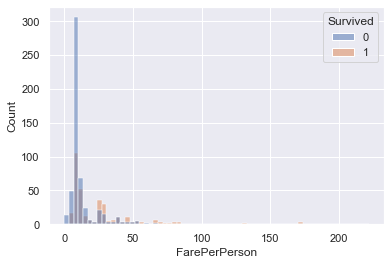

In [39]:
sns.histplot(x='FarePerPerson', data=df, hue='Survived')
plt.show()



 Die extrem hohen Preise scheinen sehr starke Ausreißer zu sein, was das Lesen des Plots erschwert. Wir beschränken
 deshalb die Plotting-Range in `x`. Zusätzlich schneiden beschränken wir auch `y` um höhere Preise besser untersuchen
 zu können:

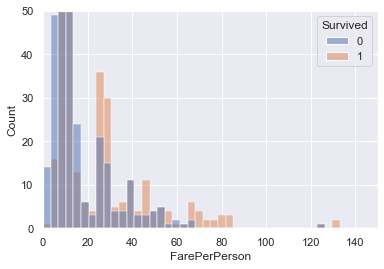

In [40]:
sns.histplot(x='FarePerPerson', data=df, hue='Survived')
plt.xlim(0, 150)
plt.ylim(0, 50)
plt.show()


 Auffällig viele Passagiere in den niedrigen Preisklassen haben die Reise nicht überlebt. Da der Preis mit der Klasse
 korrelieren sollte, ist dies jedoch nicht verwunderlich. Jedoch scheinen Leute mit sehr hohen Ticketpreisen sehr gute
 Chancen zu haben. Von den Leuten, die 0$ gezahlt haben verunglückten die meisten! Aufgrund dieser Überlegungen legen
 wir auch für `Fare` Kategorien fest, die wir in einem neuen Feature `FareCat` speichern.

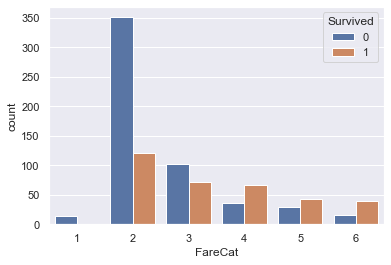

Survived  FareCat
0         2          351
          3          102
          4           36
          5           30
          6           16
          1           14
1         2          121
          3           72
          4           66
          5           43
          6           39
          1            1
Name: FareCat, dtype: int64

In [41]:
df['FareCat'] = pd.cut(df['FarePerPerson'], bins=[-1, 1, 10, 20, 30, 50, np.inf], labels=[1, 2, 3, 4, 5, 6]).astype(int)
sns.countplot(x='FareCat', data=df, hue='Survived')
plt.show()
df.groupby(['Survived'])['FareCat'].value_counts()


 Unsere Einteilung zeigt sogar, das nur eine Person mit einem Preis von 0\$ überlebt hat!

In [42]:
df[(df['FareCat'] == 1) & (df['Survived'] == 1)]


Survived  Pclass                          Name  Sex   Age  SibSp  \
PassengerId                                                                     
272                 1       3  Tornquist, Mr. William Henry    0  25.0      0   

             Parch Ticket  Fare Cabin  ... Title_Misc.  Title_Miss.  \
PassengerId                            ...                            
272              0   LINE   0.0   NaN  ...           0            0   

             Title_Mr.  Title_Mrs.  AgeCat  FamilySize  GroupSize  \
PassengerId                                                         
272                  1           0       4           1          4   

             PersonPerTicket  FarePerPerson  FareCat  
PassengerId                                           
272                        4            0.0        1  

[1 rows x 22 columns]

 __ANMERKUNG:__
 Wenn nicht alle Passagiere eines Tickets im Trainingsset sind (z.B. teilweise im Testset oder gar nicht vorhanden),
 dann kann von der ermittelten Zahl der Personen pro Ticket nicht exakt auf den pro-Kopf-Preis geschlossen werden.
 Dies wird von uns hier jedoch vernachlässigt.

In [43]:
#
# TODO: ### 3.2.8) Kabinennummer `Cabin`
# `Cabin`: Kabinennummer (nur für sehr wenige Passagiere vorhanden). Der Buchstabe steht für das Deck, was eventuell
# ein wichtiges Indiz für die Evakuierbarkeit des Passagiers zulässt.
#
# TODO: ### 3.2.9) Starthafen `Embarked`
# `Embarked`: Hafen, an dem der Passagier an Bord gegangen ist (drei Möglichkeiten: Southampton, Cherbourg,
# Queenstown). Eventuell korreliert dieser mit der Klasse (Reichtum der Bewohner an den Häfen?). Eventuell wird dieses
# Feature aber auch weggelassen, da es keinen großen Einfluss auf die Überlebenschancen haben sollte.



 ### 3.2.10) FeatureTransformer Klasse
 Im Folgenden fassen wir unsere Überlegungen über die ursprünglichen Features des Datensets in einer Transformer-Klasse
 zusammen, welche uns vorhandene Features bei Bedarf umformt, neue Features erstellt und zu guter Letzt Features
 droppt, die wir nicht für die Modelle benötigen:

In [44]:
class TitanicFeatureTransformer(BaseEstimator, TransformerMixin):

    def __init__(self):
        # TODO: We could use some flags here to customize the transform behaviour!
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, copy=True):
        assert isinstance(X, pd.DataFrame), 'This transformer is designed to work on pandas DataFrames!'
        if copy:
            X = X.copy()
        # Create new `Title` feature and create a new numeric feature for each different title:
        X['Title'] = X['Name'].str.extract(pat='([A-Z][a-z]+\.)')
        X['Title'][~X['Title'].isin(['Mr.', 'Miss.', 'Mrs.', 'Master.'])] = 'Misc.'
        X = pd.get_dummies(X, columns=['Title'])
        # Replace `Sex` string entries with 0/1:
        X.replace({'male': 0, 'female': 1}, inplace=True)
        # Categorize `Age` Feature:
        X['AgeCat'] = pd.cut(X['Age'], bins=[0, 5, 12, 18, 25, 35, 60, np.inf], labels=[1, 2, 3, 4, 5, 6, 7]).astype(int)
        # Create new feature `FamilySize`:
        X['FamilySize'] = X['SibSp'] + X['Parch'] + 1  # +1: Person itself
        # Create new feature `GroupSize` (not necessarily relatives):
        X['GroupSize'] = X['Ticket'].map(X['Ticket'].value_counts())
        # Categorize `Fare` Feature:
        X['PersonPerTicket'] = X['Ticket'].map(X['Ticket'].value_counts())
        X['FarePerPerson'] = X['Fare'] / X['PersonPerTicket']
        bins, labels = [-1, 1, 10, 20, 30, 50, np.inf], [1, 2, 3, 4, 5, 6]
        X['FareCat'] = pd.cut(X['FarePerPerson'], bins=bins, labels=labels).astype(int)
        # Drop all non-used features:
        drop = ['Age', 'Name', 'SibSp', 'Parch', 'Ticket', 'PersonPerTicket', 'Fare', 'FarePerPerson']
        X.drop(drop, axis=1, inplace=True)
        return X


class TitanicMinMaxScaler(MinMaxScaler):

    def transform(self, X, **kwargs):
        assert isinstance(X, pd.DataFrame), 'This scaler is designed to work on pandas DataFrames!'
        array_scaled = super().transform(X, **kwargs)  # The normal Scaler returns a numpy array instead of a DataFrame!
        return pd.DataFrame(data=array_scaled, columns=X.columns)


df = df_train.copy()
imputer = TitanicImputer()
transformer = TitanicFeatureTransformer()
scaler = TitanicMinMaxScaler()

df_imputed = imputer.fit_transform(df)
df_transformed = transformer.fit_transform(df_imputed)
df_scaled = scaler.fit_transform(df_transformed)
df_scaled.info()
df_scaled.describe()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Survived       891 non-null    float64
 1   Pclass         891 non-null    float64
 2   Sex            891 non-null    float64
 3   Title_Master.  891 non-null    float64
 4   Title_Misc.    891 non-null    float64
 5   Title_Miss.    891 non-null    float64
 6   Title_Mr.      891 non-null    float64
 7   Title_Mrs.     891 non-null    float64
 8   AgeCat         891 non-null    float64
 9   FamilySize     891 non-null    float64
 10  GroupSize      891 non-null    float64
 11  FareCat        891 non-null    float64
dtypes: float64(12)
memory usage: 83.7 KB


Survived      Pclass         Sex  Title_Master.  Title_Misc.  \
count  891.000000  891.000000  891.000000     891.000000   891.000000   
mean     0.383838    0.654321    0.352413       0.044893     0.030303   
std      0.486592    0.418036    0.477990       0.207186     0.171516   
min      0.000000    0.000000    0.000000       0.000000     0.000000   
25%      0.000000    0.500000    0.000000       0.000000     0.000000   
50%      0.000000    1.000000    0.000000       0.000000     0.000000   
75%      1.000000    1.000000    1.000000       0.000000     0.000000   
max      1.000000    1.000000    1.000000       1.000000     1.000000   

       Title_Miss.   Title_Mr.  Title_Mrs.      AgeCat  FamilySize  \
count   891.000000  891.000000  891.000000  891.000000  891.000000   
mean      0.204265    0.580247    0.140292    0.598391    0.090460   
std       0.403390    0.493796    0.347485    0.223849    0.161346   
min       0.000000    0.000000    0.000000    0.000000    0.000000   
25%       0.000000    0.000000    0.000000    0.500000    0.000000   
50%       0.000000    1.000000    0.000000    0.666667    0.000000   
75%       0.000000    1.000000    0.000000    0.666667    0.100000   
max       1.000000    1.000000    1.000000    1.000000    1.000000   

        GroupSize     FareCat  
count  891.000000  891.000000  
mean     0.131313    0.380022  
std      0.226857    0.251924  
min      0.000000    0.000000  
25%      0.000000    0.200000  
50%      0.000000    0.200000  
75%      0.166667    0.600000  
max      1.000000    1.000000

 # 4) Applying Machine Learning Algorithms

 ## 4.1) Creating a pipeline

In [45]:
X = df_train.drop(['Survived'], axis=1)
y = df_train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')


X_train.shape: (712, 10)
y_train.shape: (712,)


In [46]:
pipeline = make_pipeline(TitanicImputer(), TitanicFeatureTransformer(), TitanicMinMaxScaler())
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)



In [47]:
def best_grid_params(grid_search, add_columns=None, sort_by='mean_test_score', ascending=False, n=5):
    columns = ['mean_test_score', 'std_test_score', 'params']
    if add_columns is not None:
        columns.extend(add_columns)
    df_cvres = pd.DataFrame.from_dict(grid_search.cv_results_)[columns]
    df_params = df_cvres['params'].apply(pd.Series)
    df_result = pd.concat((df_cvres.drop(['params'], axis=1), df_params), axis=1)
    df_result['mean_test_score'] = (100*df_result['mean_test_score']).map('{:.2f}%'.format)
    df_result['std_test_score'] = (100*df_result['std_test_score']).map('{:.2f}%'.format)
    return df_result.sort_values(by=sort_by, ascending=ascending).head(n)



 ## 4.2) Algorithm 1: DecisionTree
 ### 4.2.1) Flacher DecisionTree für Intuition
 Zunächst wollen wir mittels eines Baumes mit geringer Tiefe eine erste Intuition entwickeln, was die Entscheidungs-
 grundlagen für die folgenden Algorithmen sein könnten. Decision Trees helfen hierbei, da man sie leicht visualisieren
 kann und man außerdem Informationen über die Features mit der größten Wichtigkeit erhält. Wir wählen zu diesem Zweck
 erstmal eine maximale Tiefe von `max_depth=4`, damit der Plot nicht zu unübersichtlich wird.

In [48]:
model = DecisionTreeClassifier(max_depth=4, random_state=SEED)
model = model.fit(X_train, y_train)


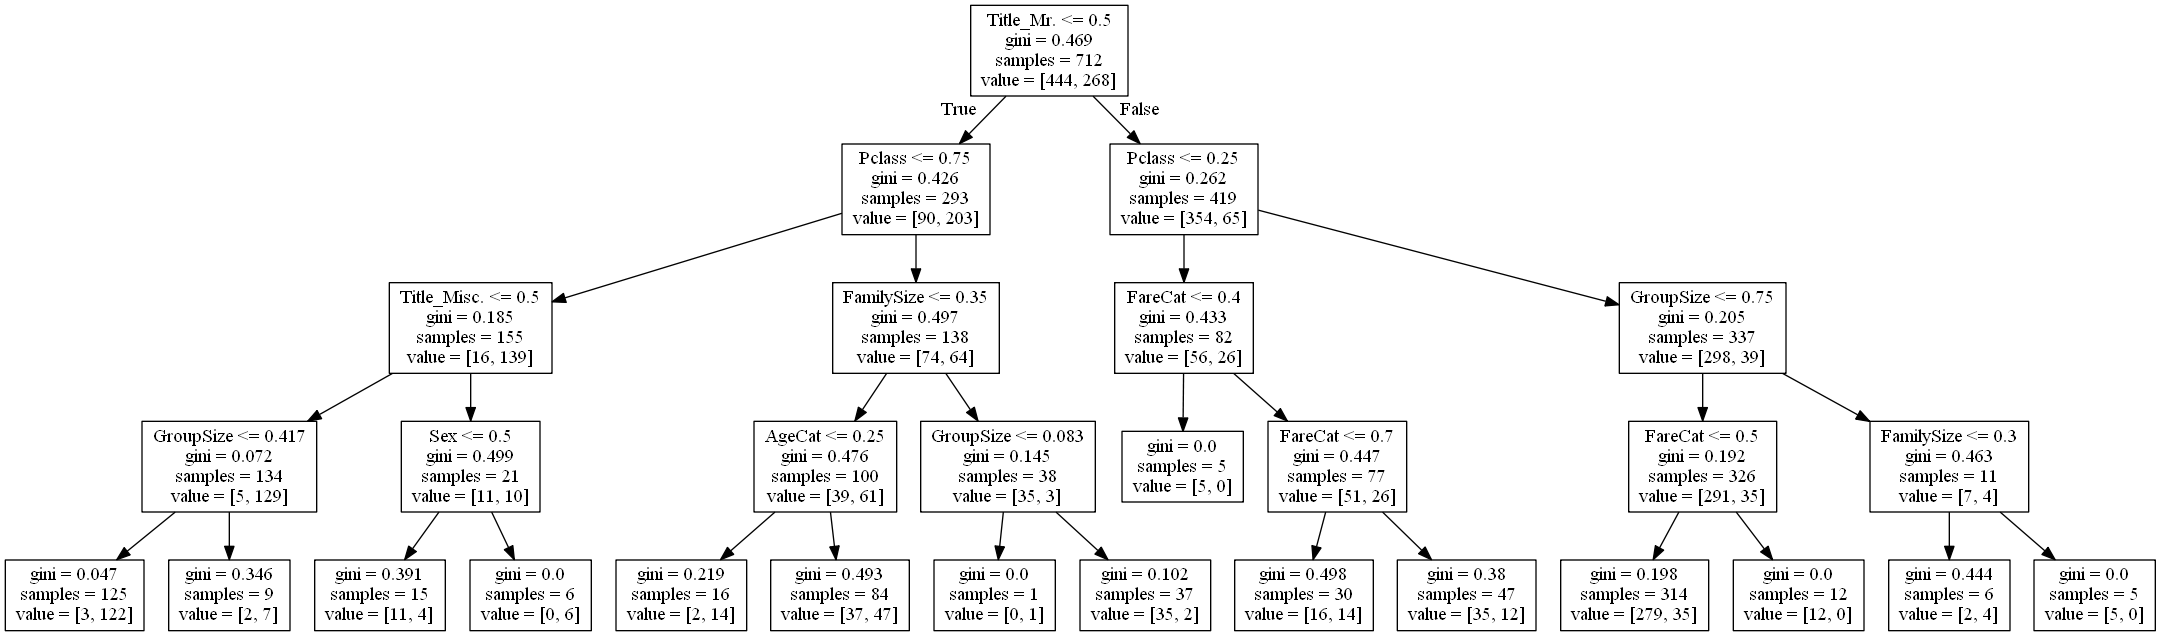

In [49]:
try:
    from graphviz import Source
    from IPython.display import Image, display
    graph = Source(export_graphviz(model, out_file=None, feature_names=X_train.columns))
    png_bytes = graph.pipe(format='png')
    with open('dtree.png','wb') as f:
        f.write(png_bytes)
    display(Image(png_bytes))
except ModuleNotFoundError:
    plot_tree(model)
    plt.show()


In [50]:
print(pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False))


Title_Mr.        0.576142
Pclass           0.189089
FamilySize       0.103757
Title_Misc.      0.049659
Sex              0.026636
GroupSize        0.021958
FareCat          0.017299
AgeCat           0.015459
Title_Master.    0.000000
Title_Miss.      0.000000
Title_Mrs.       0.000000
dtype: float64


 Das Feature `Title_Mr.` war für unseren Baum das wichtigeste Entscheidungskriterium. Unserer Meinung nach ist es sogar
 mächtiger als `Sex`, welches in der anfänglichen Korrelationsbetrachtung sehr stark mit der Überlebenschance
 korreliert war. `Title_Mr.` vereinigt Informationen über das Geschlecht, als auch über das Alter in sich und hat von
 daher einen hohen Informationsgehalt. "Master", also Jungen, sind zwar auch männlich, wurden aber viel häufiger
 gerettet als Männer höheren Alters, was das Feature `Title_Mr.` gut trennen kann. Da `Title_Mr.` bereits Informationen
 über das Geschlecht enthält, wird dieses lediglich im `False`-Part nach der `Title_Mr.`-Abfrage benötigt und zwar
 erst im Falle einer positiven Entscheidung für die Kategorie `Title_Misc.`, welche als einziger Titel Frauen und
 Männer enthält.

 ### 4.2.2) Cross Validation mit Decision Tree
 Das Trainingsset wird in 5 Sub-Sets eingeteilt, von denen iterativ eine als Testmenge benutzt wird. Mit den jeweils
 übrigen Daten wird der Algorithmus trainiert. Damit bleiben die eigentlichen Validierungsdaten unberührt und die
 Voraussagefähigkeit des Algorithmus ist besser einzuschätzen als bei Verwendung einer festen Trainings- und
 Validierungsmenge.

In [51]:
def calculate_cv(model, X_train, y_train, cv=5):
    scores_dict = cross_validate(model, X_train, y_train, cv=cv, return_train_score=True)
    df_score = pd.DataFrame.from_dict(scores_dict)
    mean_series = df_score.mean().rename('mean')
    std_series = df_score.std().rename('std')
    df_score = df_score.append([mean_series, std_series])
    df_score['test_score'] = (100*df_score['test_score']).map('{:.2f}%'.format)
    df_score['train_score'] = (100*df_score['train_score']).map('{:.2f}%'.format)
    return df_score

calculate_cv(model, X_train, y_train)


fit_time    score_time test_score train_score
0     0.005018  1.998901e-03     84.62%      83.83%
1     0.002998  1.999140e-03     80.42%      82.95%
2     0.003998  1.998425e-03     77.46%      84.21%
3     0.002998  2.000093e-03     80.28%      84.21%
4     0.004503  1.998425e-03     83.80%      83.51%
mean  0.003903  1.998997e-03     81.32%      83.74%
std   0.000901  6.868773e-07      2.91%       0.53%

 Interessanterweise ist schon dieser, doch recht kurze, Baum bereits recht gut darin einen hohen Cross-Validation-Score
 zu erreichen (im Vergleich zu anderen Ergebnissen online):

 # <img src="kaggle_scores.png">

 Aufgrund des recht hohen Scores scheint uns der Decision Tree Classifier ein geeigneter Algorithmus für unser Datenset
 zu sein. Im nächsten Schritt wollen wir daher seine Parameter optimieren.

 ## 4.2.3) Grid Search für verschiedene Parameter im Decision Tree:
 Um die bestmöglichen Parameter für optimale Voraussagefähigkeit des Decision Trees zu ermitteln, verwenden wir einen
 Grid Search. Die Parameter, die wir variieren wollen, sind 'Max Depth' und 'Criterion'. Die Tiefe des Baums sollte
 beschränkt sein um ein Overfitting zu vermeiden. Für die Aufteilung an den Knoten kann man zwischen den Kriterien
 'Gini' (Inhomogenität der Entstehenden Gruppen) und 'Entropy' (Informationsgewinn durch die Teilung) wählen.

In [52]:
# Parameter für DesicionTree Gridsearch: unterschiedliche Tiefen und Entscheidungskriterien:
param_grid = {"max_depth":[1, 3, 4, 5, 6, 7, 8, 10, 20, None], "criterion":["gini", "entropy"]}
decision_tree = DecisionTreeClassifier(random_state=SEED)
grid_search = GridSearchCV(decision_tree, param_grid, return_train_score=True, cv=5)
grid_search.fit(X_train, y_train)

print('Beste Parameter-Kombinationen Gridsearch:')
df_decision_tree_results = best_grid_params(grid_search)
df_decision_tree_results


Beste Parameter-Kombinationen Gridsearch:


mean_test_score std_test_score criterion  max_depth
1           82.16%          2.45%      gini        3.0
12          81.88%          2.30%   entropy        4.0
16          81.74%          1.87%   entropy        8.0
11          81.60%          2.61%   entropy        3.0
2           81.32%          2.60%      gini        4.0

 Von den betrachteten Werten liefern kurze Entscheidungsbäume mit Tiefen von 3 bis 4 die besten (sehr ähnlichen)
 Scores, die Parameter 'Gini' und 'Entropy' liefern keine wesentlichen Unterschiede in den Scores. Auch bei
 unbeschränkter Baumtiefe werden schlechtere Scores erzielt, was auf Overfitting schließen lässt, bei dem zwar die
 Trainings-, nicht aber die Validierungsdaten gut vorhergesagt werden.

 Wir hatten nicht erwartet, dass die Scores so kurzer Entscheidungsbäume schon bei 82 % liegen würden, sondern hatten
 eher deutlich niedrigere Werte erwartet. Zu beachten ist jedoch, dass nur der Mittelwert bei 82 % liegt und wir
 Schwankungen von ca. `std_test_score=2.5%` beim "besten" Baum zu verzeichnen haben. Falls andere Algorithmen
 mit ähnlichem Mittelwert kleinere Schwankungen aufweisen, so wären diese dem DecisionTree vorzuziehen.

 ## 4.3) Algorithmus 2: Categorical Naive Bayes
 Wenn man davon ausgeht, dass bestimmte Features die Wahrscheinlichkeit das Schiffsunglück zu überleben erhöhen oder
 erniedrigen, dann kann man auch einen Bayes-Algorithmus anwenden. Den 'Categorical Naive Bayes' halten wir für
 unsere Daten am passendsten, da sie kategorischer Art sind, aber nicht ausschließlich binär.

 Allerdings erwarten wir etwas schlechtere Scores, da unsere Features nicht gänzlich von einander unabhängig sind, wie
 es für diesen Algorithmus eigentlich Voraussetzung ist.

In [53]:
bayes_clf = CategoricalNB()
model = bayes_clf.fit(X_train, y_train)
df_bayes_results = calculate_cv(model, X_train, y_train)
df_bayes_results



fit_time  score_time test_score train_score
0     0.004995    0.002998     81.12%      78.73%
1     0.003998    0.001999     81.12%      78.73%
2     0.004996    0.002000     73.94%      80.53%
3     0.003997    0.001999     76.76%      81.23%
4     0.007994    0.001999     83.80%      78.07%
mean  0.005196    0.002199     79.35%      79.46%
std   0.001642    0.000447      3.94%       1.35%

 Die Scores für den Categorical Naive Bayes liegen im Mittel bei unter 80 %, also wie wir erwartet hatten, etwas unter
 denen der Decision Trees, wobei die Standardabweichung fast doppelt so hoch ist. `train_score` und `test_score`
 Mittelwerte sind sehr ähnlich, was dafür spricht, dass nicht overfitted wurde.

 ## 4.4) Algorithmus 3: KNeighbors Classifier
 Für nicht kontinuierliche Daten eignet sich auch der 'Kneighbors'-Algorithmus. Mit den ursprünglichen Daten hätten wir
 diesen dennoch nicht benutzen können, da Features mit Strings oder mehreren nicht ordinalen Einträgen sich nicht
 sinnvoll verarbeiten lassen. Da wir unsere Daten aufbereitet haben, so dass in den einzelnen Features entweder nur
 jeweils skalierte Binärwerte oder Ordinalwerte stehen, lassen sich Abstände berechnen. Wir wollen testen, ob der
 Parameter 'Distance' sich sinnvoll anwenden lässt, weil wir uns nicht sicher sind. Wir behalten die Euklidische Norm
 bei, weil die Daten keine spezielle Norm erfordern.

In [54]:
KN_clf = KNeighborsClassifier(weights='distance')
model = KN_clf.fit(X_train, y_train)
print("Scores mit cross_val: (weights = distance)")
calculate_cv(model, X_train, y_train)


Scores mit cross_val: (weights = distance)


fit_time  score_time test_score train_score
0     0.003999    0.003996     83.22%      89.81%
1     0.002999    0.003998     81.12%      89.46%
2     0.004997    0.002998     78.17%      89.47%
3     0.004997    0.002999     80.99%      89.82%
4     0.007027    0.020985     79.58%      88.60%
mean  0.004804    0.006995     80.61%      89.43%
std   0.001493    0.007837      1.89%       0.50%

In [55]:
KN_clf = KNeighborsClassifier(weights='uniform')
model = KN_clf.fit(X_train, y_train)
print("Scores mit cross_val: (weights = uniform)")
calculate_cv(model, X_train, y_train)


Scores mit cross_val: (weights = uniform)


fit_time  score_time test_score train_score
0     0.003999    0.007994     83.22%      85.76%
1     0.003997    0.007996     81.12%      85.24%
2     0.003997    0.012994     77.46%      85.79%
3     0.003997    0.008995     81.69%      86.14%
4     0.007996    0.022987     78.17%      85.26%
mean  0.004797    0.012193     80.33%      85.64%
std   0.001788    0.006376      2.43%       0.38%

 Bei beiden Einstellungen für `weight` ist zu verzeichnen, dass der `train_score` deutlich höher ist als der
 `test_score` (außerhalb der Standardabweichungen). Dies deutet darauf hin, dass der KNearestNeighbor-Algorithmus in
 diesem Fall anfällig für Overfitting ist (für `weight='distance` sogar noch deutlich mehr).

 Alleine den Parameter `weights` zu variieren ändert den Cross-Validation-Score nicht besonders. Deshalb wollen wir
 als nächstes auch beim KNearestNeighbors Algorithmus einen GridSearch versuchen. Dazu variieren wir die Anzahl der
 nächsten Nachbarn, den `weights` parameter, so wie oben bereits probiert und wir variieren zusätzlich die Norm
 zwischen euklidischer (`p=2`) und der Manhattan Norm (`p=1`):

In [56]:
neighbor_range = list(range(1, 21)) + [25, 30, 50, 100]
param_grid = {"n_neighbors": neighbor_range, "p": [1,2], "weights": ["distance", "uniform"]}
KN_clf = KNeighborsClassifier()
grid_search = GridSearchCV(KN_clf, param_grid, return_train_score=True, cv=6)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=6, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 25, 30,
                                         50, 100],
                         'p': [1, 2], 'weights': ['distance', 'uniform']},
             return_train_score=True)

In [57]:
print('Beste Parameterkombinationen Grid Search:')
df_kneighbors_results = best_grid_params(grid_search, n=10)
df_kneighbors_results


Beste Parameterkombinationen Grid Search:


mean_test_score std_test_score  n_neighbors  p  weights
49          82.31%          4.28%           13  1  uniform
45          82.16%          4.10%           12  1  uniform
37          82.16%          4.37%           10  1  uniform
53          82.16%          3.99%           14  1  uniform
41          82.02%          4.48%           11  1  uniform
33          81.88%          4.56%            9  1  uniform
31          81.88%          3.99%            8  2  uniform
51          81.74%          5.30%           13  2  uniform
57          81.74%          5.53%           15  1  uniform
29          81.60%          3.76%            8  1  uniform

 Der K-Nächste-Nachbarn-Algorithmus mit 13 Nachbarn, Manhattan-Norm und uniformen Gewichten ist hier als Gewinner
 hervorgegangen und ist im Score vergleichbar mit dem besten DecisionTree von zuvor. Allerdings schwankt die
 Vorhersagekraft aufgrund der höheren Standardabweichung (4.3 %) deutlich stärker. Für uns ist der KNearestNeighbor
 deshalb nicht der Algorithmus der Wahl.

 ## 4.5) Ensemble Learning mit Random Forest Classifier
 Zu guter Letzt wollen wir noch einen Ensemble-Classifier ausprobieren und haben uns aufgrund der bisher bereits guten
 Performance des DecisionTrees für den Random Forest entschieden. Zuerst schauen wir uns einen Forest exemplarisch an:

In [58]:
forest_clf= RandomForestClassifier(n_estimators=100, random_state=SEED)
model = forest_clf.fit(X_train, y_train)
calculate_cv(model, X_train, y_train)


fit_time  score_time test_score train_score
0     0.244870    0.032980     81.82%      89.81%
1     0.236865    0.015992     83.22%      89.63%
2     0.219296    0.012994     80.28%      89.65%
3     0.210878    0.014991     80.99%      89.82%
4     0.222871    0.012991     81.69%      88.77%
mean  0.226956    0.017990     81.60%      89.54%
std   0.013720    0.008480      1.09%       0.44%

 Unser erster Versuch war nicht schlecht, jedoch ist sicher eine bessere Parameterkonfiguration zu finden, die wir
 erneut mittels CVGridSearch suchen. Hierbei variieren wir die Anzahl der Bäume/Estimatoren, deren maximale Tiefe,
 sowie dem `bootstrap` Parameter, den wir an und aus schalten:

In [59]:
param_grid = {"n_estimators":[10, 50, 100, 150], "max_depth":[1, 2, 3, 4, 5, 6], "bootstrap":[True, False]}
random_forest_clf = RandomForestClassifier(random_state=SEED)
grid_search = GridSearchCV(random_forest_clf, param_grid, return_train_score=True, cv=5)
grid_search.fit(X_train, y_train)
print(grid_search)
print('Beste Parameter Gridsearch für RandomForestClassifier:')
df_random_forest_results = best_grid_params(grid_search, add_columns=['mean_fit_time', 'mean_score_time', 'mean_train_score'])
df_random_forest_results


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [1, 2, 3, 4, 5, 6],
                         'n_estimators': [10, 50, 100, 150]},
             return_train_score=True)
Beste Parameter Gridsearch für RandomForestClassifier:


mean_test_score std_test_score  mean_fit_time  mean_score_time  \
12          83.00%          2.61%       0.020989         0.003798   
33          82.86%          2.16%       0.062903         0.008395   
15          82.86%          1.74%       0.252669         0.017990   
34          82.72%          2.34%       0.138921         0.013792   
13          82.72%          1.85%       0.094252         0.007996   

    mean_train_score  bootstrap  max_depth  n_estimators  
12          0.832158       True          4            10  
33          0.831808      False          3            50  
15          0.841642       True          4           150  
34          0.833213      False          3           100  
13          0.840235       True          4            50

 Der beste Random Forest ergab einen `mean_test_score=83.0%`, wobei der `mean_train_score=83.2%` betrug, was bedeutet,
 dass weder over- noch underfitted wurde. Die Standardabweichung von `std_test_score=2.6%` ist auch relativ klein.

 ## 4.6) Finales Model

Der best estimator aus dem Gridsearch zeigt im Vergleich zu allen anderen getesteten Algorithmen die
beste Verlässlichkeit (Std.abw für Cross validation), geringes Overfitting und eine gute Vorhersagekraft (Score).
Im Letzten Schritt wird das finale Modell also auf den im Vorfeld abgetrennten Test-Daten angewendet.
Dabei erreicht das finale Modell einen Train-Score von 83% und einen relativ nahe daran liegenden Test-Score.

In [60]:
final_model = grid_search.best_estimator_

final_train_score = final_model.score(X_train, y_train)
final_test_score = final_model.score(X_test, y_test)

print(f'Final train score: {100*final_train_score:.2f}%')
print(f'Final test  score: {100*final_test_score:.2f}%')



Final train score: 83.43%
Final test  score: 80.45%


 # 5) Fazit

(75, 90)

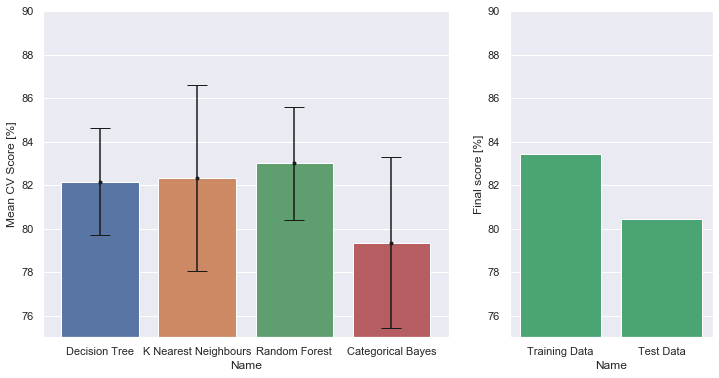

In [61]:
df_list = [('Decision Tree', df_decision_tree_results),
           ('K Nearest Neighbours', df_kneighbors_results),
           ('Random Forest', df_random_forest_results),
           ('Categorical Bayes', df_bayes_results)]

entry_list = []
for name, df in df_list:
    if name == 'Categorical Bayes':
        score = df['test_score'].loc['mean']
        std = df['test_score'].loc['std']
    else:
        score = df['mean_test_score'].iloc[0]
        std = df['std_test_score'].iloc[0]
    entry_list.append([name, score, std])

df_cv_plot = pd.DataFrame(entry_list, columns=['Name', 'Mean CV Score [%]', 'Std CV Score [%]'])
df_cv_plot.set_index('Name')
df_cv_plot['Mean CV Score [%]'] = df_cv_plot['Mean CV Score [%]'].str.replace('%', '').astype(float)
df_cv_plot['Std CV Score [%]'] = df_cv_plot['Std CV Score [%]'].str.replace('%', '').astype(float)

final_list = [['Training Data', 100*final_train_score],
              ['Test Data', 100*final_test_score]]
df_final_plot = pd.DataFrame(final_list, columns=['Name', 'Final score [%]'])
df_final_plot.set_index('Name')

fig, axes = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [2, 1]})
sns.barplot(data=df_cv_plot, x='Name', y='Mean CV Score [%]', capsize=.2, ax=axes[0])
axes[0].errorbar(x=range(4),
                 y=df_cv_plot['Mean CV Score [%]'].values,
                 yerr=df_cv_plot['Std CV Score [%]'].values,
                 fmt='.k', capsize=10)
axes[0].set_ylim(75, 90)
sns.barplot(data=df_final_plot, x='Name', y='Final score [%]', color='mediumseagreen', ax=axes[1])
axes[1].set_ylim(75, 90)


 Wurden Frauen und Kinder zuerst gerettet?
 Folgendes konnte bereits anhand eines Blicks auf die vorliegenden Datensätze bereits festgestellt werden: Von 577
 männlichen Passagieren sind 486 gestorben (84 %) und von den 314 weiblichen Passagieren nur 81 (25 %). Somit ist
 wahrscheinlich, dass das Geschlecht zumindest einen großen Einfluss auf die Überlebenschance hatte.

 Das Datenset beinhaltet die Datensätze von 891 der über 1300 Passagiere, die eine Überfahrt auf der Titanic gebucht
 hatten, also ungefähr 68 %. Somit sind die Aussagen, die das Datenset liefern kann, begrenzt. Eine detaillierte
 Untersuchung der Daten sollte Aufschluss darüber geben, welche Faktoren für das Überleben noch eine Rolle gespielt
 haben. Bereits bei einem kurzen Überblick mit einem kurzen Entscheidungsbaum der Tiefe 4 wurde klar, dass das Feature
 ‚Titel Mr.‘, welches die Eigenschaften ‚männlich‘ und ‚älter als 18‘ vereint, einen entscheidenden Einfluss auf die
 Überlebenschance hat.

 Um die Frage zu beantworten, wie genau wir vorhersagen können, ob ein Passagier überlebt hat oder nicht, haben wir
 folgende Algorithmen verglichen:

 - Decision Tree

 - Random Forest

 - Categorical Naive Bayes

 - KNeigbors


 Diese bieten sich am ehesten für die Untersuchung unserer kategorischen Daten an.

 Insgesamt erhalten wir auch in der Menge der getesteten Algorithmen mit den Entscheidungsbäumen des Random Forest die
 effizientesten Vorhersagen mit dem besten Score und der besten Standardabweichung. Auch liefert er ähnliche Werte für
 Trainings- und Testdaten.

 # 6) Lessons learned

 ## 6.1) Was wir mitnehmen aus dem Projekt

 - Es lohnt sich, ausführlich in die Daten zu schauen und ggf. neue Kategorien zu bilden, weil man dadurch

   - die Weiterverarbeitung sehr vereinfachen

   - die Algorithmen verkürzen

   - und die Voraussagen optimieren kann.

 - Die reine Datenvorverarbeitung kostet bereits genauso viel oder sogar mehr Zeit, als die Durchführung des ML und die
   Bewertung der Algorithmen und ihrer Vorhersagefähigkeit.

 - Es gibt Abstände zwischen kategorialen Daten, aber man sollte sich bewusst machen, wie die Algorithmen diese
   verwerten. Beispielsweise könnte der KneighborsClassifier Features übergewichten, die nach dem Skalieren nur Nullen
   und Einsen enthalten gegenüber Features, die Werte zwischen Null und Eins haben. Unsere ausführlichen Diskussionen
   haben sehr zum Verstehen der Daten beigetragen.

 - Man darf nicht vergessen, dass die Testdaten NaNs an anderen Stellen enthalten können, als die Trainingsdaten. Daher
   sollte man sich vorher überlegen (und auch testen), wie man damit umgeht.

 - Es ist aus 2 Gründen absolut sinnvoll, die Dokumentation gleich ausführlich zum Code dazuzuschreiben:

   1.  Weil man schon am nächsten Tag nicht mehr unbedingt weiß, warum man einen bestimmten Parameter getestet hat.
       Häufig liest man sich kurz ein und dann ist es hilfreich, das Fazit notiert zu haben.

   2.  Die Dokumentation kostet viel Zeit. Verschiebt man sie aufs Projektende, ist die Zeit zu knapp.

 - Für die Dokumentation ist es sehr hilfreich ein Programm zu benutzen, dass Kommentare und Code-Teile in pdfs
   überführen kann.

 - Es ist nicht notwendig, aber sehr hilfreich, wenn alle mit demselben Programm arbeiten (Python-Version,
   Interpreter). VSCode eignet sich leider besser als PyCharm (leider, weil es nicht bei allen funktioniert hat).

 - Eine gute Programmierumgebung ist extrem hilfreich, da sie enorm viel Zeit spart.

 - Coden ist nicht das eigentliche Lernziel, sondern Machine Learning ist ein spannender Anlass um sich Coden anhand
   von konreten Projekten beizubringen.

 - Ein Projekt mit mehreren Personen ist eigentlich immer interessant, weil so viele verschiedene Blickwinkel, Ideen
   und Vorkenntnisse zusammenkommen.

 - Pandas ist ein sehr mächtiges Paket zur Manipulation von Datensätzen und zur Feature Generierung, aber auch zur
   übersichtlichen Darstellung von Daten. Ohne viel Erfahrung ist die Lernschwelle jedoch sehr hoch.

 - Obwohl man auch Matplotlib benutzen könnte ist Seaborn für statistische Plots vorzuziehen, vor allem, da man sehr
   viel Zeit sparen kann, wenn man die Integration von Panda Datenframes nutzt, ohne sich um die Formatierung kümmern
   zu müssen.

 - Denken in mehr als 3 Dimensionen ist nicht immer einfach...

 - Sabine:

   - Ich persönlich glaube, dass ich mehr vom Kurs und vom Projekt profitiert hätte, wenn ich schon bessere
     Vorkenntnisse gehabt hätte. Viele Informationen sind nicht hängen geblieben, weil zu viel gänzlich neu war.

   - Schriftliche, exakt formulierte Aufgabenstellungen sind extrem hilfreich, wenn man eh unsicher ist.

   - Zum Kurs: Für mich als Anfänger im Coden wäre es hilfreicher gewesen, kleine Programmier-Aufgaben (wirklich kleine)
     zu Anfang zu bekommen (und wenn es nur 1 – 2 pro Tag sind), deren Lösungen am nächsten Tag auch besprochen werden
     (Vormachen oder Musterlösung), ggf. von der Hauptgruppe getrennt nur für die, die es brauchen.

 ## 6.2) Was wir mit mehr Zeit noch hätten machen können

 - Die starken Schwankungen beim Cross Validation Score könnten eventuell mit der Aufteilung des K-Fold Split (hier
   `K=5`) zu tun haben, falls die Passagierliste eine gewisse Vorsortierung besaß. Es könnte sich lohnen, einen
   zuvor einen ShuffleSplit laufen zu lassen um diesen Effekt potentiell zu reduzieren.

 - Einen Boosting-Algorithmus auszuprobieren wäre noch interessant gewesen.

 - Neuronale Netze können prinzipiell jede Funktion approximieren und wären deswegen auch ein Kandidat gewesen, den man
   noch hätte testen können.

 - Eventuell wäre eine PCA interessant gewesen um zu sehen, ob es überflüssige Features gibt, die man weglassen kann.

 - Wir haben die Features `Cabin` und `Embarked` verworfen (aus Gründen der Unvollständigkeit und der Intuition, dass
   der Starthafen keinen Einfluss haben sollte), mit mehr Zeit hätte man aus diesen Daten eventuell aber auch noch
   Informationen ziehen können (beispielsweise das `Deck` aus der Kabinennummer).